In [23]:
import os
from tqdm import tqdm

from sage.config.config import DataArguments, TrainingArguments, MiscArguments

from sage.config import get_logger, logger_conf
from sage.data import get_dataloader
from sage.utils import seed_everything

from nilearn import plotting
import nibabel
import numpy as np
import pickle

from sage.legacy.miccai_analysis import *
from sage.legacy.resnet import *

import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
from tqdm import tqdm
import torch
from captum.attr import LayerGradCam, LayerAttribution

In [2]:
base_path = "/Volumes/WD_BLACK/May 12 2022 Backup/3DCNN_sMRI"

get_path = lambda f: os.path.join(base_path, f)

In [3]:
with open(get_path("./data/naive_reg_test_100.pkl"), "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open(get_path("./data/augment_reg_test_100.pkl"), "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [4]:
with open(get_path("./data/naive_nonreg_test_100.pkl"), "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open(get_path("./data/augment_nonreg_test_100.pkl"), "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [5]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [6]:
def first_reached_indices(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

def first_reached_maes(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    maes = [find_first_reached(ckpts, point)[1] for ckpts in raw_data[config]]
    return list(filter(lambda x: x != -1, maes)), mean(list(filter(lambda x: x != -1, maes)))

In [7]:
from glob import glob

ckpt_path = "/Volumes/WD_BLACK/May 12 2022 Backup/checkpoints(MICCAI2022)"
seeds = sorted(glob(ckpt_path + "/resnet256_naive_checkpoints/*"))
ckpts = sorted(glob(seeds[0] + "/*"))

from pathlib import Path

Path(seeds[0])

PosixPath('/Volumes/WD_BLACK/May 12 2022 Backup/checkpoints(MICCAI2022)/resnet256_naive_checkpoints/20211130-1429_resnet')

In [8]:
def load_model_ckpts(path: Path, epoch: int):

    path = Path(path) if isinstance(path, str) else path

    epoch = str(epoch).zfill(3)
    ckpts = dict()
    for model_name in ("encoder", "regressor"):

        ckpt = list(path.glob(f"./{model_name}/ep{epoch}*.pt"))
        assert len(ckpt) == 1
        ckpts[model_name] = ckpt[0]

    mae = float(str(ckpt[0]).split("mae")[-1].split(".pt")[0])

    return ckpts, mae

In [9]:
load_model_ckpts(seeds[0], 0)

resnet = load_resnet()
regressor = load_predictors["nkregressor"]()
model = Assembled(resnet, regressor)

In [10]:
ckpt_dict, mae = load_model_ckpts(seeds[0], 0)
model.load_weight(ckpt_dict)

Weights successfully loaded!


In [14]:
len(seeds), len(first_reached_indices("naive", 8)[0])

(100, 100)

In [22]:
data_args, training_args, misc_args = (
    DataArguments(),
    TrainingArguments(),
    MiscArguments(),
)
seed_everything(misc_args.seed)
misc_args.output_dir = "./"
# data_args.batch_size = 1

logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

2022-06-08 21:37:25,562 - root - INFO - Initialize dataset.
2022-06-08 21:37:25,574 - root - INFO - Successfully setup 146 brains for Test


In [30]:
from sage.xai.utils import z_norm, _z_norm, average, _nifti

ImportError: cannot import name '_nifti' from 'sage.xai.utils' (/Users/daehyuncho/codespace/brain-age-prediction/sage/xai/utils.py)

In [27]:
for path, ckpt_idx in zip(seeds, first_reached_indices("naive", 7.27)[0]):

    model = Assembled(resnet, regressor)
    conv_layers = model.conv_layers()
    ckpt_dict, mae = load_model_ckpts(path, ckpt_idx)
    model.load_weight(ckpt_dict)

    layer_and_map = {}
    for layer_idx, conv_layer in enumerate(tqdm(conv_layers)):

        # logger.info(f"Layer {layer_idx}: {conv_layer}")
        layer_gc = LayerGradCam(model, conv_layer)

        saliency_map = []
        maps = None
        for x, y in tqdm(test_dataloader):

            # x, y = map(lambda x: x.to("cuda"), (x, y))
            attr = layer_gc.attribute(x)
            upsampled_attr = (
                LayerAttribution.interpolate(
                    attr, (96, 96, 96), interpolate_mode="trilinear"
                )
                .cpu()
                .detach()
            )
            z_normed = z_norm(upsampled_attr)
            saliency_map.append(upsampled_attr)
            maps = torch.cat((maps, z_normed), dim=0) if maps is not None else z_normed

        layer_and_map[layer_idx] = maps

    break

Weights successfully loaded!


100%|██████████| 9/9 [01:33<00:00, 10.38s/it]


In [31]:
AVG = np.load("./data/average.npy")
_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, np.eye(4))

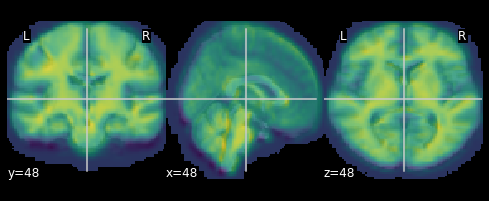

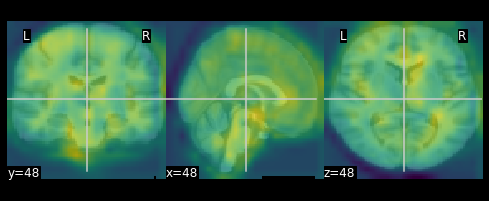

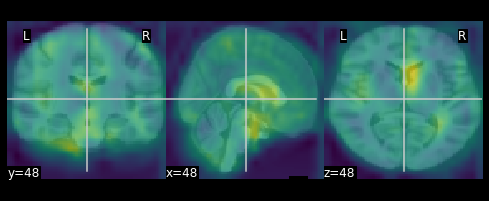

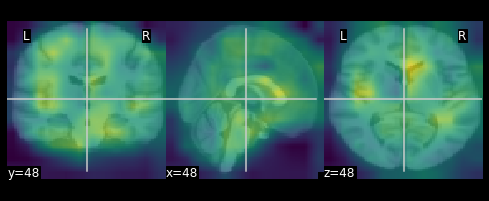

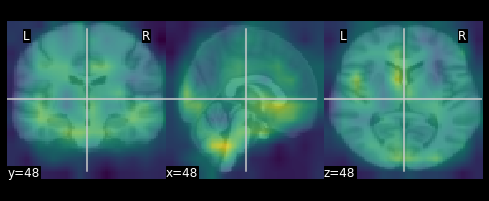

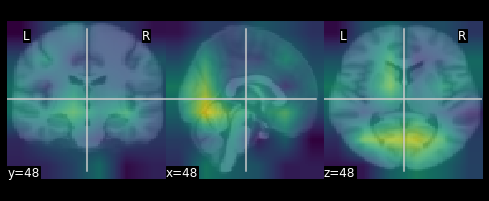

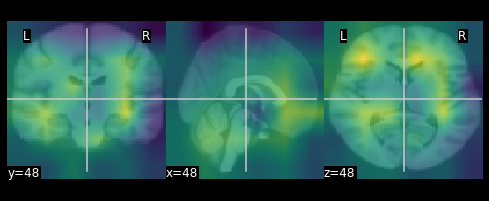

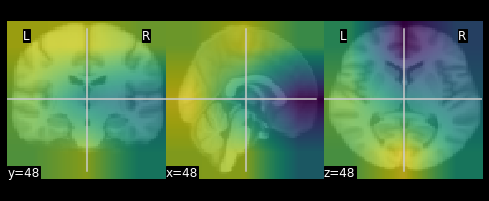

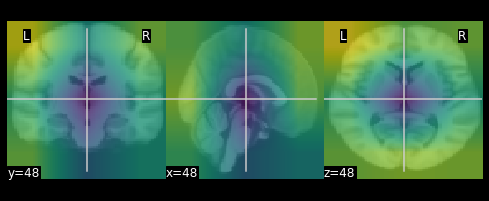

In [34]:
cut_coords = (48, 48, 48)
for layer_idx, saliency_map in layer_and_map.items():

    avg_map = average(saliency_map, 0).squeeze()
    null_val = torch.mode(avg_map.flatten(), 0).values

    # model.stage0.rbr_dense.conv
    display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
    display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7)

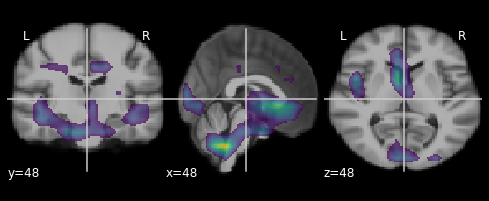

In [37]:
avg_map = average(layer_and_map[4], 0).squeeze()
null_val = torch.mode(avg_map.flatten(), 0).values

# model.stage0.rbr_dense.conv
display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7, threshold=.6)

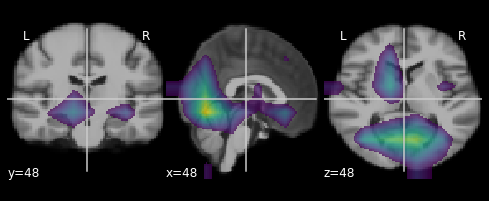

In [41]:
avg_map = average(layer_and_map[5], 0).squeeze()
null_val = torch.mode(avg_map.flatten(), 0).values

# model.stage0.rbr_dense.conv
display = plotting.plot_anat(_nifti(AVG), cut_coords=cut_coords)
display.add_overlay(_nifti((avg_map - null_val).detach().numpy()), alpha=.7, threshold=.2)